## Description

### Problem

#### Objective:
Energy savings is one of the important area of focus our current world. Energy savings has two key elements:

* Forecasting future energy usage without improvements
* Forecasting energy use after a specific set of improvements have been implemented

Once we have implemented a set of improvements, the value of energy efficiency improvements can be challenging as there's no way to truly know **how much energy a building would have used without the improvements**. The best we can do is to build counterfactual models. 

We build these counterfactual models across four energy types:
* **chilled water**
* **electricity**
* **hot water**
* **steam**

based on historic usage rates and observed weather.

### Data

#### Dataset:
The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

##### train.csv

* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* `timestamp` - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

##### building_meta.csv

* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

##### weather_[train/test].csv

Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

##### test.csv

The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

* `row_id` - Row id for your submission file
* `building_id` - Building id code
* `meter` - The meter id code
* `timestamp` - Timestamps for the test data period

## Loading Data

#### TO DO:

* load data tables


* join train and metadata tables
* join train and weather tables

Import necessary libraries.

In [1]:
# work with data
import pandas as pd
import numpy as np

# plotting issues
import seaborn as sns
from matplotlib import pyplot as plt

# statistics calculation
from statistics import median

# value encoders
from sklearn.preprocessing import LabelEncoder

# technical issues
import os
%matplotlib inline

In [2]:
%%time
building_metadata = pd.read_csv('data' + os.sep + 'building_metadata.csv')

Wall time: 66.9 ms


In [3]:
%%time
train_data = pd.read_csv('data' + os.sep + 'train.csv')

Wall time: 31.6 s


In [ ]:
# %%time
# test = pd.read_csv('data' + os.sep + 'test.csv')

In [ ]:
# weather_train = pd.read_csv('data' + os.sep + 'weather_train.csv')

In [ ]:
# weather_test = pd.read_csv('data' + os.sep + 'weather_test.csv')

In [ ]:
# rename timestamps columns
# train.columns = ['building_id', 'meter', 'ti   mestamp_meter', 'meter_reading']
# test.columns = ['row_id', 'building_id', 'meter', 'timestamp_meter']

# weather_train.columns = ['site_id', 'timestamp_weather', 'air_temperature', 'cloud_coverage', 'dew_temperature', \
#                         'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
# weather_test.columns = ['site_id', 'timestamp_weather', 'air_temperature', 'cloud_coverage', 'dew_temperature', \
#                         'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

In [ ]:
# test_data = building_metadata.copy()
# test_data = test_data.join(test.set_index('building_id'), on='building_id', how='inner')
# test_data.head()

In [ ]:
# test_data.shape

In [4]:
train_data = train_data.join(building_metadata.set_index('building_id'), on='building_id', how='inner')
train_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
2301,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
4594,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN
6893,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN
9189,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN


In [5]:
train_data.shape

(20216100, 9)

Create a copy of train data for EDA

In [7]:
train_copy = train_data.copy()

In [35]:
train_data_electricity = train_data[train_data['meter'] == 0]
train_data_chilledWater = train_data[train_data['meter'] == 1]
train_data_steam = train_data[train_data['meter'] == 2]
train_data_hotWater = train_data[train_data['meter'] == 3]

In [7]:
train_data_electricity.shape

(12060910, 9)

In [8]:
train_data_chilledWater.shape

(4182440, 9)

In [9]:
train_data_steam.shape

(2708713, 9)

In [10]:
train_data_hotWater.shape

(1264037, 9)

## Preprocessing

### Data Cleaning

#### TO DO:

* NaNs counting
* How to fill the blanks?


* Some columns processing (LabelEncoder/...)
* Preprocessing for each building
* Split table into features and targets

In [36]:
def ConvertDate(train_data):
    # Convert date to datetime format
    train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
    
    # Extract and store year, month, day, hour
    train_data['year'] = train_data['timestamp'].dt.year
    train_data['month'] = train_data['timestamp'].dt.month
    train_data['day'] = train_data['timestamp'].dt.day
    train_data['hour'] = train_data['timestamp'].dt.hour
    
    train_data.drop(['timestamp'], axis=1, inplace=True)

In [37]:
ConvertDate(train_data_electricity)
ConvertDate(train_data_chilledWater)
ConvertDate(train_data_steam)
ConvertDate(train_data_hotWater)

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [14]:
train_data_electricity.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,year,month,day,hour
0,0,0,0.0,0,Education,7432,2008.0,NaN,2016,1,1,0
2301,0,0,0.0,0,Education,7432,2008.0,NaN,2016,1,1,1
4594,0,0,0.0,0,Education,7432,2008.0,NaN,2016,1,1,2
6893,0,0,0.0,0,Education,7432,2008.0,NaN,2016,1,1,3
9189,0,0,0.0,0,Education,7432,2008.0,NaN,2016,1,1,4


In [15]:
train_data_chilledWater.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,year,month,day,hour
3172286,7,1,1857.26,0,Education,121074,1989.0,NaN,2016,2,29,9
3174385,7,1,2659.25,0,Education,121074,1989.0,NaN,2016,2,29,10
3176488,7,1,2912.51,0,Education,121074,1989.0,NaN,2016,2,29,11
3178590,7,1,3039.15,0,Education,121074,1989.0,NaN,2016,2,29,12
3180681,7,1,3207.99,0,Education,121074,1989.0,NaN,2016,2,29,13


In [16]:
train_data_steam.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,year,month,day,hour
894,745,2,0.0,6,Education,13512,NaN,NaN,2016,1,1,0
3193,745,2,0.0,6,Education,13512,NaN,NaN,2016,1,1,1
5488,745,2,0.0,6,Education,13512,NaN,NaN,2016,1,1,2
7786,745,2,0.0,6,Education,13512,NaN,NaN,2016,1,1,3
10081,745,2,0.0,6,Education,13512,NaN,NaN,2016,1,1,4


In [17]:
train_data_hotWater.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,year,month,day,hour
105,106,3,0.0,1,Education,5374,NaN,4.0,2016,1,1,0
2406,106,3,10.0,1,Education,5374,NaN,4.0,2016,1,1,1
4699,106,3,10.0,1,Education,5374,NaN,4.0,2016,1,1,2
6998,106,3,10.0,1,Education,5374,NaN,4.0,2016,1,1,3
9294,106,3,0.0,1,Education,5374,NaN,4.0,2016,1,1,4


In [38]:
def CreateMeanMeterReading(train_data, buildings_number):
    new_columns = list(train_data.columns)
    new_columns.append('meter_reading_mean')

    train = pd.DataFrame(columns=new_columns)

    building_ids = train_data['building_id'].unique()[1:buildings_number]
    train_data_cutted = train_data[train_data['building_id'] == train_data['building_id'].unique()[0]]
    for building_id in building_ids:
        train_data_cutted = train_data_cutted.append(train_data[train_data['building_id'] == building_id], ignore_index=True)
    
    for building_id in train_data_cutted['building_id'].unique():
        buildingID = train_data_cutted[train_data_cutted['building_id'] == building_id]
        for month_id in buildingID['month'].unique():
            buildingIDmonthID = buildingID[buildingID['month'] == month_id]
            for day_id in buildingIDmonthID['day'].unique():
                buildingIDmonthIDdayID = buildingIDmonthID[buildingIDmonthID['day'] == day_id]
                train = train.append(buildingIDmonthIDdayID[0:1], ignore_index=True)
                train.set_value(train.shape[0]-1, 'meter_reading_mean', buildingIDmonthIDdayID['meter_reading'].mean())
    
    train = train.drop(['hour', 'year', 'building_id', 'floor_count', 'meter_reading', 'meter'], axis=1)
    train['primary_use'] = LabelEncoder().fit_transform(train['primary_use'])
    train = train.apply(pd.to_numeric)
    return train

In [39]:
train_electricity = CreateMeanMeterReading(train_data_electricity, 10)
train_chilledWater = CreateMeanMeterReading(train_data_chilledWater, 10)
train_steam = CreateMeanMeterReading(train_data_steam, 10)
train_hotWater = CreateMeanMeterReading(train_data_hotWater, 10)

C:\Users\Alexander\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [20]:
train_electricity.head()

,day,meter_reading_mean,month,primary_use,site_id,square_feet,year_built
0,1,0.0,1,0,0,7432,2008.0
1,2,0.0,1,0,0,7432,2008.0
2,3,0.0,1,0,0,7432,2008.0
3,4,0.0,1,0,0,7432,2008.0
4,5,0.0,1,0,0,7432,2008.0


In [21]:
train_chilledWater.head()

,day,meter_reading_mean,month,primary_use,site_id,square_feet,year_built
0,29,2600.158400,2,0,0,121074,1989.0
1,1,2230.113667,3,0,0,121074,1989.0
2,2,2462.269708,3,0,0,121074,1989.0
3,3,2212.526250,3,0,0,121074,1989.0
4,4,1953.987667,3,0,0,121074,1989.0


In [22]:
train_steam.head()

,day,meter_reading_mean,month,primary_use,site_id,square_feet,year_built
0,1,0.000000,1,0,6,13512,NaN
1,2,0.000000,1,0,6,13512,NaN
2,3,3.753125,1,0,6,13512,NaN
3,4,226.378058,1,0,6,13512,NaN
4,5,242.507912,1,0,6,13512,NaN


In [23]:
train_hotWater.head()

,day,meter_reading_mean,month,primary_use,site_id,square_feet,year_built
0,1,11.250000,1,0,1,5374,NaN
1,2,11.250000,1,0,1,5374,NaN
2,3,7.500000,1,0,1,5374,NaN
3,4,12.083333,1,0,1,5374,NaN
4,5,12.608696,1,0,1,5374,NaN


### Exploratory Data Analysis

In [11]:
train = train_copy.copy()

First things first, we need to know, how much data is missing.

In [85]:
missing_numbers = {}
for column in train_data.columns:
  number_of_nans = len(train_data[column]) - train_data[column].count()
  if (number_of_nans > 0):
    missing_numbers[column] = number_of_nans
missing_numbers_df = pd.DataFrame(list(missing_numbers.items()), columns=['Feature', 'Number of missing values'])

(array([0, 1]), <a list of 2 Text xticklabel objects>)

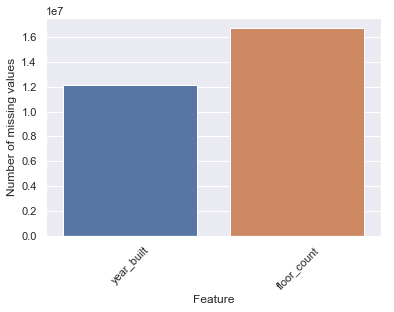

In [86]:
g = sns.barplot(y=missing_numbers_df['Number of missing values'], x=missing_numbers_df['Feature'])
# g.set_xticklabels(rotation=30)
plt.xticks(rotation=45)

We need to either drop or fill missing values in columns "year_built" and "floor_count". The decision will be made after more analysis.

C:\Users\Alexander\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


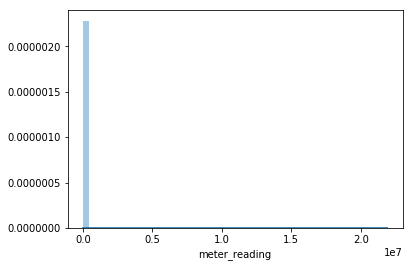

In [12]:
sns.distplot(train['meter_reading'])

As we can see, data contains several really big values in meter readings. We consider them as outliers. To tackle them we are trimming our data to 95-percentile in meter readings.

In [13]:
train_copy = train[ train['meter_reading'] < np.quantile(train['meter_reading'], 0.95)]

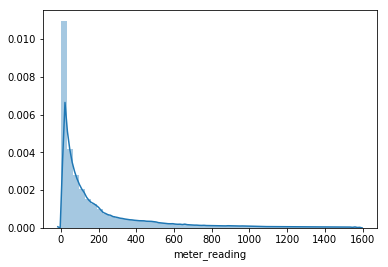

In [14]:
sns.distplot(train_copy['meter_reading'])

Meter reading variable is very skewed so we can try to apply logarithmic transformation to it.

In [16]:
train_copy['meter_reading_log'] = train_copy['meter_reading'].apply(lambda x: np.log(1+x))

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


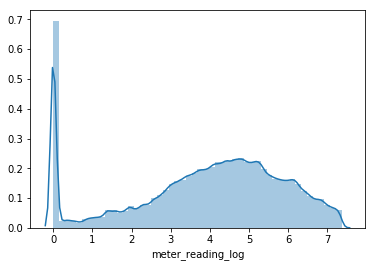

In [17]:
sns.distplot(train_copy['meter_reading_log'])

And after that distribution of meter readings looks more symmetric

In [18]:
train_copy.timestamp = pd.to_datetime(train_copy.timestamp)
train_copy['year'] = train_copy.timestamp.dt.year
train_copy['month'] = train_copy.timestamp.dt.month
train_copy['day'] = train_copy.timestamp.dt.day
train_copy['hour'] = train_copy.timestamp.dt.hour

C:\Users\Alexander\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

If we take a look at median meter reading vs hour of the day, we can notice that the majority of energy is consumed during the day

In [20]:
median_hour = train_copy.groupby('hour').median()
median_hour.reset_index(inplace=True)

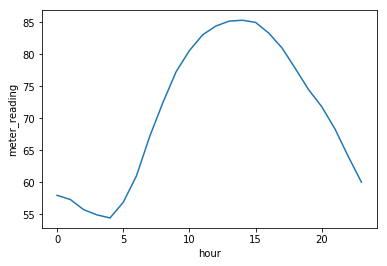

In [21]:
sns.lineplot(x='hour', y='meter_reading', data=median_hour)

Speaking about most energy consuming months, Junr-September is the time period when meter readings are on the highest level 

In [22]:
median_timestamp = train_copy.groupby('timestamp').median()
median_timestamp.reset_index(inplace=True)

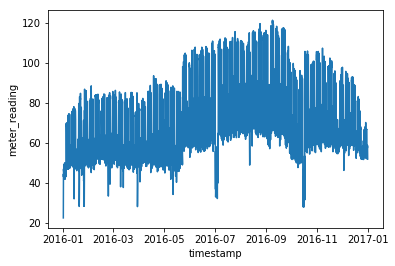

In [23]:
sns.lineplot(x='timestamp', y='meter_reading', data=median_timestamp)

In [40]:
number_by_categories = train_data.groupby('primary_use').count()
number_by_categories.reset_index(inplace=True)
number_by_categories = number_by_categories.set_index('primary_use')
number_by_categories.head(30)

,building_id,meter,timestamp,meter_reading,site_id,square_feet,year_built,floor_count
primary_use,,,,,,,,
Education,8165504,8165504,8165504,8165504,8165504,8165504,4051418,1911191
Entertainment/public assembly,2264917,2264917,2264917,2264917,2264917,2264917,841529,468655
Food sales and service,114090,114090,114090,114090,114090,114090,26343,0
Healthcare,398527,398527,398527,398527,398527,398527,77500,8784
Lodging/residential,2146413,2146413,2146413,2146413,2146413,2146413,1068349,152602
Manufacturing/industrial,125713,125713,125713,125713,125713,125713,55441,26352
Office,4394864,4394864,4394864,4394864,4394864,4394864,1076179,356542
Other,242222,242222,242222,242222,242222,242222,56438,124358
Parking,213796,213796,213796,213796,213796,213796,117206,20589


In [41]:
number_by_categories_series = number_by_categories['meter_reading']
number_by_categories_series = number_by_categories_series.sort_values(ascending=False)

(array([      0., 1000000., 2000000., 3000000., 4000000., 5000000.,
        6000000., 7000000., 8000000., 9000000.]),
 <a list of 10 Text xticklabel objects>)

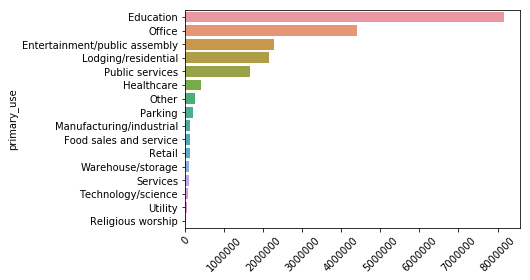

In [42]:
g = sns.barplot(y=number_by_categories_series.index, x=number_by_categories_series.values)
# g.set_xticklabels(rotation=30)
plt.xticks(rotation=45)

According to the barplot, most readings are obtained for the "Education" type buildings, consequently it is likely that better results will be achieved for buildings of this type.

C:\Users\Alexander\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


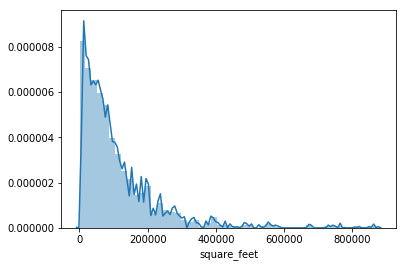

In [43]:
sns.distplot(train_data['square_feet'])

Total area of buildings is skewed but there are not so many outliers.

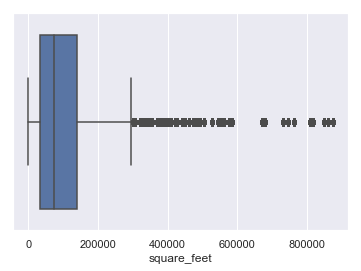

In [81]:
sns.boxplot(train_data['square_feet'])

Dataset contains 4 types of meter but number of readings might be to different between those types.

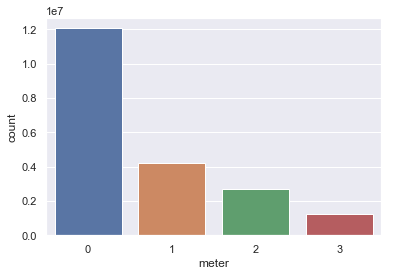

In [83]:
sns.countplot(train_data['meter'])

There are more readings of electricity than readings of all other meter types, therefore our main priority will be to predict electricity readings.

Take a look at correlation of features with our target "meter_reading"

In [65]:
TR = train_copy.drop(['meter_reading_log', 'timestamp'], axis=1)

In [66]:
TR['primary_use'] = LabelEncoder().fit_transform(TR['primary_use'])

In [67]:
correlation = TR.corr()

In [68]:
correlation.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,year,month,day,hour
building_id,1.000000,0.197652,0.114828,0.980673,0.059921,0.073179,-0.234167,-0.401291,NaN,0.019296,-0.000388,0.000923
meter,0.197652,1.000000,0.154858,0.228114,-0.082682,0.113018,-0.005900,0.170663,NaN,0.010079,0.000111,0.000238
meter_reading,0.114828,0.154858,1.000000,0.126673,-0.083044,0.399734,0.151834,0.358947,NaN,0.029174,0.003368,0.025097
site_id,0.980673,0.228114,0.126673,1.000000,0.078623,0.076393,-0.200750,-0.387482,NaN,0.019023,-0.000454,0.000592
primary_use,0.059921,-0.082682,-0.083044,0.078623,1.000000,-0.088531,0.073653,-0.201586,NaN,-0.001398,0.000399,0.000185


(array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 8 Text xticklabel objects>)

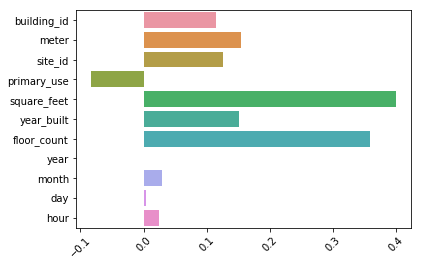

In [69]:
correlation_series = correlation['meter_reading'].drop(['meter_reading'])
g = sns.barplot(x=correlation_series.values, y=correlation_series.index)
# g.set_xticklabels(rotation=30)
plt.xticks(rotation=45)

Since correlation of features "year_built" and "floor_count" with the target is noticeable we will fill NaNs rather than drop these columns.

Inspect correlation of different powers of features (e.g. floor_count^2) with the target

In [70]:
# target = TR['meter_reading_mean']
# features = TR.drop(['meter_reading_mean'], axis=1)
target = TR['meter_reading']
features = TR.drop(['meter_reading'], axis=1)

In [71]:
features.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,year,month,day,hour
0,0,0,0,0,7432,2008.0,NaN,2016,1,1,0
2301,0,0,0,0,7432,2008.0,NaN,2016,1,1,1
4594,0,0,0,0,7432,2008.0,NaN,2016,1,1,2
6893,0,0,0,0,7432,2008.0,NaN,2016,1,1,3
9189,0,0,0,0,7432,2008.0,NaN,2016,1,1,4


In [72]:
target.head()

0       0.0
2301    0.0
4594    0.0
6893    0.0
9189    0.0
Name: meter_reading, dtype: float64

In [73]:
dict = {}

features_powered = features ** 2

# give columns appropriate names
data_2power = features_powered
data_2power['meter_reading_mean'] = target
correlation = data_2power.corr()
target_column = correlation['meter_reading_mean']
for i in range(target_column.shape[0]):
    key = target_column.index.values[i]
    value = target_column.iloc[i]
    dict[key] = value
correlation['meter_reading_mean'].head()
print(dict)

target_column.head()

{'building_id': 0.12924369888632728, 'meter': 0.09914704880186583, 'site_id': 0.13466581208612777, 'primary_use': -0.07577335441262072, 'square_feet': 0.29155223144884795, 'year_built': 0.15232066360396093, 'floor_count': 0.2565035017756436, 'year': nan, 'month': 0.021333251826124056, 'day': 0.0025289018085203267, 'hour': 0.01590051070246011, 'meter_reading_mean': 1.0}


building_id    0.129244
meter          0.099147
site_id        0.134666
primary_use   -0.075773
square_feet    0.291552
Name: meter_reading_mean, dtype: float64

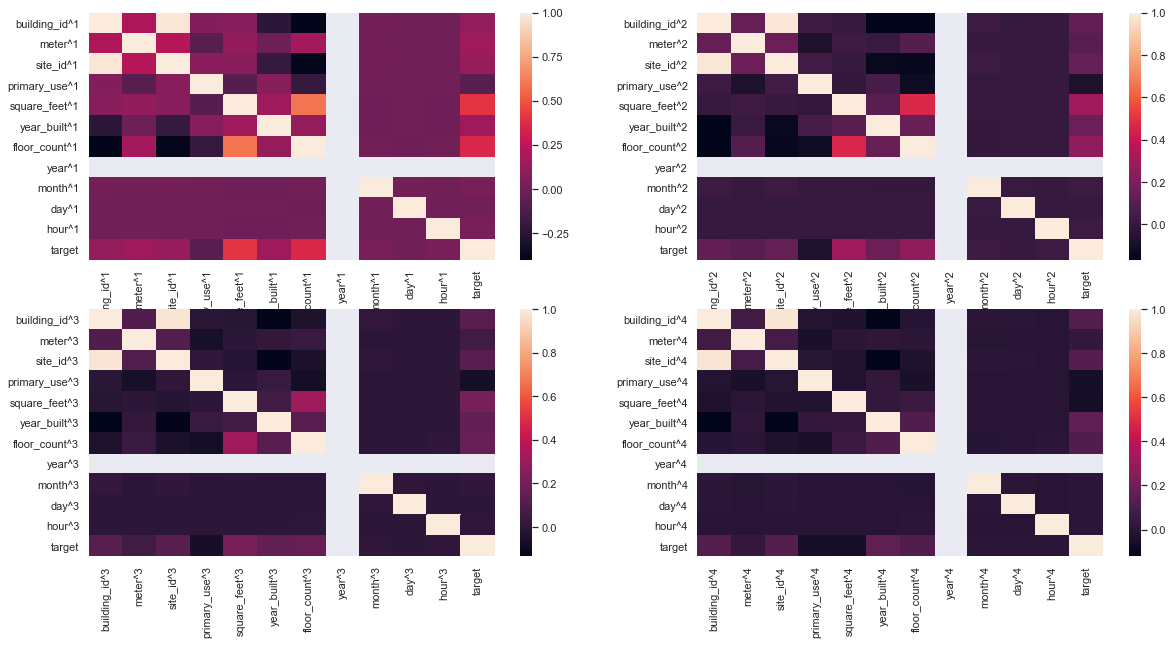

In [80]:
plt.figure(figsize=(20,10))
 
list_of_powered_features = []
features_corr_dict = {}
 
for i in range(1,5):
    new_columns = []
    features_powered = features ** i
    # give columns appropriate names
    for column in features_powered.columns:
        new_columns.append(column + '^{0}'.format(i))
    features_powered.columns = new_columns
 
    list_of_powered_features.append(features_powered)
    data_2power = features_powered
    data_2power['target'] = target
    correlation = data_2power.corr()
    # add values to the dictionary of feature correlation
    target_column = correlation['target']
    for j in range(target_column.shape[0]):
        key = target_column.index.values[j]
        if key != 'target':
            value = target_column.iloc[j]
            features_corr_dict[key] = value
 
    plt.subplot(2,2,i)
    ax = sns.heatmap(correlation)

In [75]:
sorted_features_corr_dict = sorted(features_corr_dict.items(), key=lambda kv: kv[1])

In [76]:
sorted_features_corr_dict.reverse()

#### Top 5 of correlating features

In [77]:
top5 = []

for i in range(1,6):
    feature_name = sorted_features_corr_dict[i][0]
    top5.append(feature_name)
    
print(top5)

['year^3', 'year^2', 'year^1', 'square_feet^1', 'floor_count^1']


In [78]:
top_corr_features = pd.DataFrame()
for feature in top5:
    index = int(feature[-1]) - 1
    feature_powered = list_of_powered_features[index]
    top_corr_features[feature] = feature_powered[feature]

In [87]:
top_corr_features.head()

,year^3,year^2,year^1,square_feet^1,floor_count^1
0,8193540096,4064256,2016,7432,NaN
2301,8193540096,4064256,2016,7432,NaN
4594,8193540096,4064256,2016,7432,NaN
6893,8193540096,4064256,2016,7432,NaN
9189,8193540096,4064256,2016,7432,NaN


## Metrics

#### TO DO:

* check unbalancing!
* What metrics will we use and why?

Evaluation Metric
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as $RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(p_{i}+1\right)-\log \left(a_{i}+1\right)\right)^{2}}$

We have chosen RMSLE not to penalize huge differences in the predicted and the actual values when both predicted and true values are huge numbers (in this dataset they might go up to around 7 thousand kw/h). What is more, for this paticular problem overestimating meter readings is better than underestimating them since the goal is to find how much imporovements of buildings helped reduce their energy consumption. In this case again RMSLE is more appropriate than MSE.

In [ ]:
# from sklearn.metrics import ...

## ML models

### Preprocessing

#### TO DO:

* split into train (80%) and test (val) (20%)
* OneHotEncoding for categorial features
* normalize (standardize) data

In [24]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error


random_state = 1

In [25]:
def FeatureTargetSplit(data):
    target = data['meter_reading_mean']
    features = data.drop(['meter_reading_mean'], axis=1)
    
    return features, target

In [26]:
features_electricity, target_electricity = FeatureTargetSplit(train_electricity)
features_chilledWater, target_chilledWater = FeatureTargetSplit(train_chilledWater)
features_steam, target_steam = FeatureTargetSplit(train_steam)
features_hotWater, target_hotWater = FeatureTargetSplit(train_hotWater)

In [27]:
categorical_data_indices = [2, 3]
numerical_data_indices = [0, 1, 4, 5]

In [28]:
pipe_ridge = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('encoding', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, categorical_data_indices])),
                                      ('encoding', OneHotEncoder())
                                      ])),
        ('scaling', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, numerical_data_indices])),
                                     ('scaling', StandardScaler())
                                     ]))
    ])),
    ('model', Ridge(random_state=random_state))
])

In [29]:
pipe_lasso = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('encoding', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, categorical_data_indices])),
                                      ('encoding', OneHotEncoder())
                                      ])),
        ('scaling', Pipeline(steps = [('selecting', FunctionTransformer(lambda X : X[:, numerical_data_indices])),
                                     ('scaling', StandardScaler())
                                     ]))
    ])),
    ('model', Lasso(random_state=random_state))
])

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=random_state)

### Linear model

#### TO DO:

* Choose some linear models
* Find a good combination of hyperparameters via cross-validation
* plot dependency between score and some hyperparameter

In [ ]:
# param_grid = {'model__alpha': np.logspace(-3, 3, 7, base=10)}
param_grid = {'model__alpha': [10**i for i in range(-3, 3)]}
grid_search_ridge = GridSearchCV(pipe_ridge, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_search_ridge.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % -grid_search_ridge.best_score_)
print(grid_search_ridge.best_params_)

In [ ]:
results_ridge = grid_search_ridge.cv_results_
plt.figure(figsize=[12., 9.])
plt.title("GridSearchCV for Ridge Regression")
plt.xlabel("Regularization coefficient")
plt.ylabel("MSE")

x_axis = np.array(param_grid['model__alpha'], dtype=float)
y_axis = -results_ridge['mean_test_score']
plt.plot(x_axis, y_axis)

In [ ]:
grid_search_lasso = GridSearchCV(pipe_lasso, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_search_lasso.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % -grid_search_lasso.best_score_)
print(grid_search_lasso.best_params_)

In [ ]:
results_lasso = grid_search_lasso.cv_results_
plt.figure(figsize=[12., 9.])
plt.title("GridSearchCV for Lasso Regression")
plt.xlabel("Regularization coefficient")
plt.ylabel("MSE")

x_axis = np.array(param_grid['model__alpha'], dtype=float)
y_axis = -results_lasso['mean_test_score']
plt.plot(x_axis, y_axis)

In [ ]:
from sklearn.metrics import mean_squared_error

if -grid_search_lasso.best_score_ < -grid_search_ridge.best_score_:
    fin_model = Lasso(alpha=grid_search_lasso.best_params_['model__alpha'], random_state=random_state)
else: 
    fin_model = Ridge(alpha = grid_search_ridge.best_params_['model__alpha'], random_state=random_state)

fin_model.fit(X_train, y_train)
y_pred = fin_model.predict(X_val)
mean_squared_error(y_pred, y_val)

In [30]:
def SuperGridSearch(features, target, param_grid, pipe):
    grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error') 
    grid_search.fit(features, target)
    return -grid_search_ridge.best_score_, grid_search

In [31]:
def BestModel(features, target, pipes):
    scores = []
    for name, pipe in pipes:
        score, grid = SuperGridSearch(features, target, param_grid, pipe_ridge)
        scores.append([score, name, grid])
    
    best_model = scores[0]
    for score, name, grid in scores:
        if score < best_model[0]:
            best_model = [score, name, grid]
    return best_model[1:]

In [32]:
def Predict(name, alpha, X_train, y_train, X_test):
    if (name == 'lasso'):
        model = Lasso(alpha=alpha, random_state=random_state)
    else:
        model = Ridge(alpha=alpha, random_state=random_state)
    model.fit(X_train, y_train)
    return model.predict(X_test)

In [33]:
def GetBuildingParameters(train_data):
    building_parameters = pd.DataFrame(columns=train_data.columns)

    for building_id in train_data['building_id'].unique():
        buildingID = train_data[train_data['building_id'] == building_id]
        building_parameters = building_parameters.append(buildingID[0:1], ignore_index=True)
    
    building_parameters = building_parameters.drop(['floor_count', 'timestamp', 'meter_reading', 'meter'], axis=1)
    building_parameters['primary_use'] = LabelEncoder().fit_transform(building_parameters['primary_use'])
    building_parameters = building_parameters.apply(pd.to_numeric)
    return building_parameters

In [34]:
building_parameters = GetBuildingParameters(train_data)
building_parameters.head()

,building_id,site_id,primary_use,square_feet,year_built
0,0,0,0,7432,2008.0
1,1,0,0,2720,2004.0
2,2,0,0,5376,1991.0
3,3,0,0,23685,2002.0
4,4,0,0,116607,1975.0


In [35]:
%%time
test_data = pd.read_csv('data' + os.sep + 'test.csv')

Wall time: 17.3 s


In [36]:
test_data = test_data.join(building_parameters.set_index('building_id'), on='building_id', how='inner')
test_data.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built
0,0,0,0,2017-01-01 00:00:00,0,0,7432,2008.0
129,129,0,0,2017-01-01 01:00:00,0,0,7432,2008.0
258,258,0,0,2017-01-01 02:00:00,0,0,7432,2008.0
387,387,0,0,2017-01-01 03:00:00,0,0,7432,2008.0
516,516,0,0,2017-01-01 04:00:00,0,0,7432,2008.0


In [37]:
test_data_electricity = test_data[test_data['meter'] == 0]
test_data_chilledWater = test_data[test_data['meter'] == 1]
test_data_steam = test_data[test_data['meter'] == 2]
test_data_hotWater = test_data[test_data['meter'] == 3]

In [38]:
test_data_electricity['timestamp'] = pd.to_datetime(test_data_electricity['timestamp'])
test_data_chilledWater['timestamp'] = pd.to_datetime(test_data_chilledWater['timestamp'])
test_data_steam['timestamp'] = pd.to_datetime(test_data_steam['timestamp'])
test_data_hotWater['timestamp'] = pd.to_datetime(test_data_hotWater['timestamp'])

test_data_electricity['month'] = test_data_electricity['timestamp'].dt.month
test_data_electricity['day'] = test_data_electricity['timestamp'].dt.day
test_data_electricity.drop(['timestamp'], axis=1, inplace=True)

test_data_chilledWater['month'] = test_data_chilledWater['timestamp'].dt.month
test_data_chilledWater['day'] = test_data_chilledWater['timestamp'].dt.day
test_data_chilledWater.drop(['timestamp'], axis=1, inplace=True)

test_data_steam['month'] = test_data_steam['timestamp'].dt.month
test_data_steam['day'] = test_data_steam['timestamp'].dt.day
test_data_steam.drop(['timestamp'], axis=1, inplace=True)

test_data_hotWater['month'] = test_data_hotWater['timestamp'].dt.month
test_data_hotWater['day'] = test_data_hotWater['timestamp'].dt.day
test_data_hotWater.drop(['timestamp'], axis=1, inplace=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

In [39]:
test_data_electricity = test_data_electricity.drop(['meter', 'building_id'], axis=1)
test_data_chilledWater = test_data_chilledWater.drop(['meter', 'building_id'], axis=1)
test_data_steam = test_data_steam.drop(['meter', 'building_id'], axis=1)
test_data_hotWater = test_data_hotWater.drop(['meter', 'building_id'], axis=1)

In [40]:
test_data_electricity = test_data_electricity[['row_id', 'day', 'month', 'primary_use', 'site_id', 'square_feet', 'year_built']]
test_data_chilledWater = test_data_chilledWater[['row_id', 'day', 'month', 'primary_use', 'site_id', 'square_feet', 'year_built']]
test_data_steam = test_data_steam[['row_id', 'day', 'month', 'primary_use', 'site_id', 'square_feet', 'year_built']]
test_data_hotWater = test_data_hotWater[['row_id', 'day', 'month', 'primary_use', 'site_id', 'square_feet', 'year_built']]

In [41]:
param_grid = {'model__alpha': [10**i for i in range(-3, 3)]}

In [43]:
name, grid = BestModel(features_electricity, target_electricity, [['ridge', pipe_ridge], ['lasso', pipe_lasso]])
pred_electricity = Predict(name, grid.best_params_['model__alpha'], features, target, test_data_electricity.drop('row_id', axis=1))

ValueError: unknown categorical feature present [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] during transform.

In [ ]:
pred_electricity

## Analyzing of results

#### TO DO:

* Make `test.csv` files with our results
* send them into Kaggle in turn

### Comparison of models

#### TO DO:

* Compare results of Linear and Classifier models (take test scores from kaggle)
* Write conclusion